# What Games Are Successful?

You work for the online store Ice, which sells video games worldwide.
User and expert reviews, genres, platforms (for example, Xbox or PlayStation), and historical data on game sales are available from open sources.
Your task is to identify patterns that determine whether a game is successful or not. This will allow you to spot promising projects and plan marketing campaigns.

You have data available up to 2016. Let’s imagine it’s December 2016, and you are planning a campaign for 2017.

The key objective is to gain experience working with data — it doesn’t really matter whether you are predicting 2017 sales based on 2016 data or 2027 sales based on 2026 data.

The dataset contains a column called “rating”, which stores the ESRB classification for each game.
The Entertainment Software Rating Board evaluates a game’s content and assigns an age rating, such as Teen or Adult.

# 1. Inicialization

In [1]:
# Import functions
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
# import libraries:
import pandas as pd
import numpy as np
from scipy import stats
from math import factorial
import seaborn as sns
from matplotlib import pyplot as plt

from src.null_columns import show_null_columns
from src.column_names import standard_col_names

In [ ]:
# Extract the info
df_games = pd.read_csv('../data/raw/instacart_orders.csv/df_games.csv')

# 2. Data Preprocessing

In [4]:
# General View
df_games.info()
print()
print(df_games.sample(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

                 Name Platform  Year_of_Release     Genre  NA_sales  EU_sales  \
286    FIFA Soccer 07      PS2           2006.0    Sports      0.71      2.48   
387          Tekken 4      PS2           2002.0  Fighting      1.55      1.27 

In [5]:
# Clone dataset to keep the original with no changes
df_games_clean = df_games.copy()

"""
Findings:
Reviewing the column headers, we have to standardize to snake_case
"""
standard_col_names(df_games_clean)
print()

Null Values

In [6]:
show_null_columns(df_games_clean)


Columns with null values in Dataset:
                 null_count  null_percent
critic_score           8578     51.319174
rating                 6766     40.478612
user_score             6701     40.089740
year_of_release         269      1.609333
name                      2      0.011965
genre                     2      0.011965


In [7]:
    # Columns 'name' and 'genre'
print(df_games_clean[df_games_clean['name'].isna()])

"""
Findings:
As the null values for columns 'name' and 'genre' are in the same rows, it is acceptable to remove them in order to avoid noise in the dataset
"""
df_games_clean.dropna(subset=['name','genre'], inplace=True) # Remove
#show_null_columns(df_games_clean)

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


In [8]:
    # Column 'year_of_release'
print(df_games_clean[df_games_clean['year_of_release'].isna()]) 

"""
Findings: 
As the null values represent only 1.60% of the dataset, and also this column cannot be imputed with the median/mean, as the variable is categorical
The best way to approach the missing lines is to remove them. 
"""
df_games_clean = df_games_clean.dropna(subset=['year_of_release']) # Remove
df_games_clean['year_of_release'] = df_games_clean['year_of_release'].astype(int)
#show_null_columns(df_games_clean)

                                    name platform  year_of_release  \
183                      Madden NFL 2004      PS2              NaN   
377                     FIFA Soccer 2004      PS2              NaN   
456           LEGO Batman: The Videogame      Wii              NaN   
475           wwe Smackdown vs. Raw 2006      PS2              NaN   
609                       Space Invaders     2600              NaN   
...                                  ...      ...              ...   
16373  PDC World Championship Darts 2008      PSP              NaN   
16405                      Freaky Flyers       GC              NaN   
16448                          Inversion       PC              NaN   
16458        Hakuouki: Shinsengumi Kitan      PS3              NaN   
16522                       Virtua Quest       GC              NaN   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
183          Sports      4.26      0.26      0.01         0.71          94.0   

In [9]:
    # Column 'user_score'
"""
Findings:
About column 'user_score', non-numeric values in the column are 'tbd' and 'NaN'. So converting tbd to NA to standardize non-numeric values.
"""
# Convert data in the "user_score" column, replacing "tbd" with NA
df_games_clean["user_score"] = df_games_clean["user_score"].replace("tbd", pd.NA)
df_games_clean["user_score"] = pd.to_numeric(df_games_clean["user_score"], errors="coerce")
#show_null_columns(df_games_clean)

Duplicate Values

In [10]:
print("The number of duplicated rows is:", df_games_clean.duplicated().sum())

# Review if, there's duplicated rows limited to columns: "name" + "platform" + "genre" + "year_of_release"
df_games_clean['new_column'] = (
    df_games_clean[['name', 'platform', 'genre', 'year_of_release']]
    .astype(str)
    .agg('_'.join, axis=1)
)

print("The number of duplicated values in certain columns are:", df_games_clean['new_column'].duplicated().sum())
print()
print(df_games_clean[df_games_clean['new_column'].duplicated()])

df_games_clean = df_games_clean.drop_duplicates(subset=['new_column']).reset_index(drop=True)

The number of duplicated rows is: 0
The number of duplicated values in certain columns are: 1

                name platform  year_of_release   genre  na_sales  eu_sales  \
16230  Madden NFL 13      PS3             2012  Sports       0.0      0.01   

       jp_sales  other_sales  critic_score  user_score rating  \
16230       0.0          0.0          83.0         5.5      E   

                          new_column  
16230  Madden NFL 13_PS3_Sports_2012  


Summary of Sales

In [11]:
# Calculate total sales
df_games_clean['total_sales'] = df_games_clean[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum(axis=1)

# 3. Data Analysis
### 3.1 Games per Year

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64


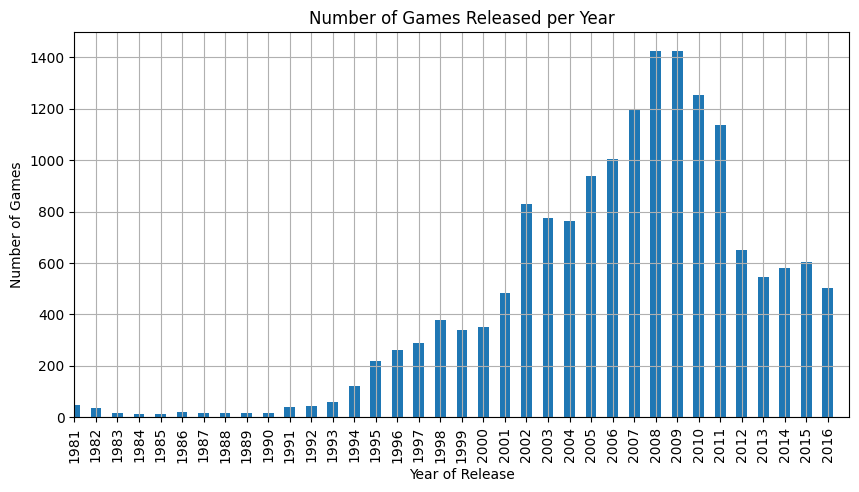

In [13]:
games_per_year = df_games_clean.groupby('year_of_release')['name'].count()
print(games_per_year)

# Visualization
games_per_year.plot(
    title="Number of Games Released per Year",
    xlabel='Year of Release',
    ylabel='Number of Games',
    grid=True,
    kind="bar",
    rot=90,
    figsize=[10,5]
)
plt.xlim(1, len(games_per_year))
plt.show()

Findings: <br>
Are the data from each period significant?
It can be observed that there is a left-skewed distribution, with most of the data concentrated between 2002 and 2011, reaching its peak in 2008 and 2009. This shows that, starting from 1994, the number of games produced increased gradually.

### 3.2 Total Sales by Platform

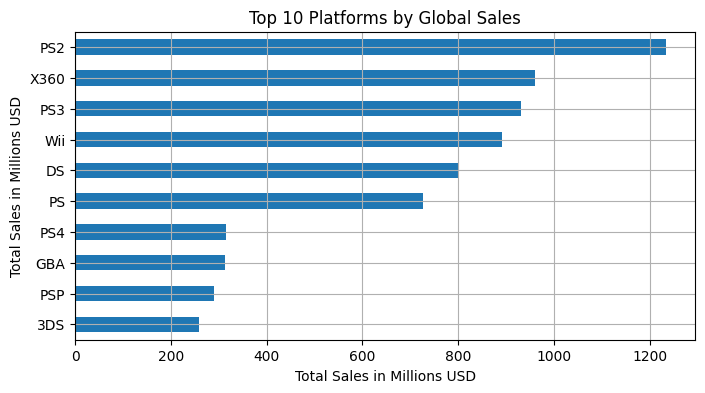

In [14]:
# Observe how sales vary from one platform to another.
sales_per_platform = df_games_clean.groupby(by='platform')['total_sales'].sum()
sales_per_platform = sales_per_platform.sort_values(ascending=False)

# Visualization
ax = sales_per_platform.head(10).plot(
    title='Top 10 Platforms by Global Sales',
    kind="barh",
    figsize=(8,4),
    grid=True,
    ylim=(15,30),
    xlabel="Platform",
    ylabel="Total Sales in Millions USD"
)
ax.set_xlabel("Total Sales in Millions USD")
ax.invert_yaxis()
plt.show()

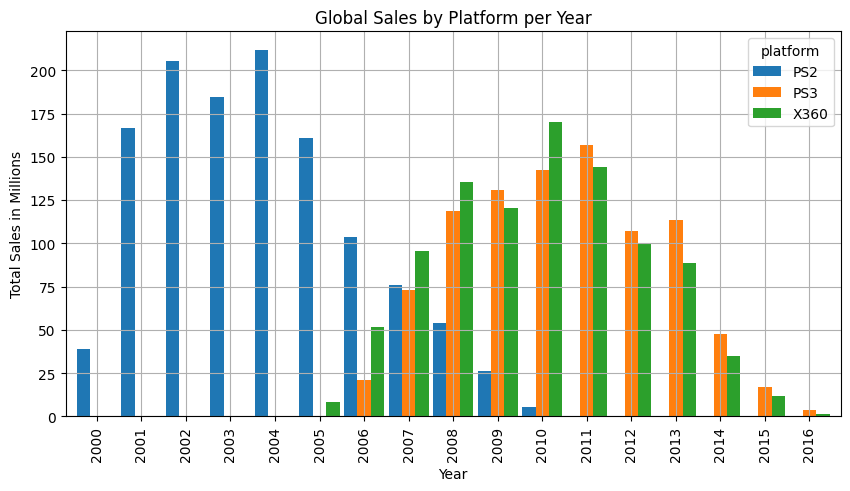

In [15]:
# Platforms with the highest total sales and distribution based on yearly data.
top_platforms = sales_per_platform.head(3).index
sales_by_year_platform = df_games_clean[df_games_clean["platform"].isin(top_platforms)].groupby(["year_of_release","platform"])\
    ["total_sales"].sum().reset_index()

# Filter by platform
pivot_sales_by_year_platform = sales_by_year_platform.pivot(index='year_of_release', columns='platform', values='total_sales')

# Visualization
pivot_sales_by_year_platform.plot(
    title='Global Sales by Platform per Year',
    kind='bar',
    grid=True,
    xlabel='Year',
    ylabel='Total Sales in Millions',
    width=0.9,
    rot=90,
    figsize=(10,5)
)
plt.show()

### 3.3 Platform Life Cycle by Brand

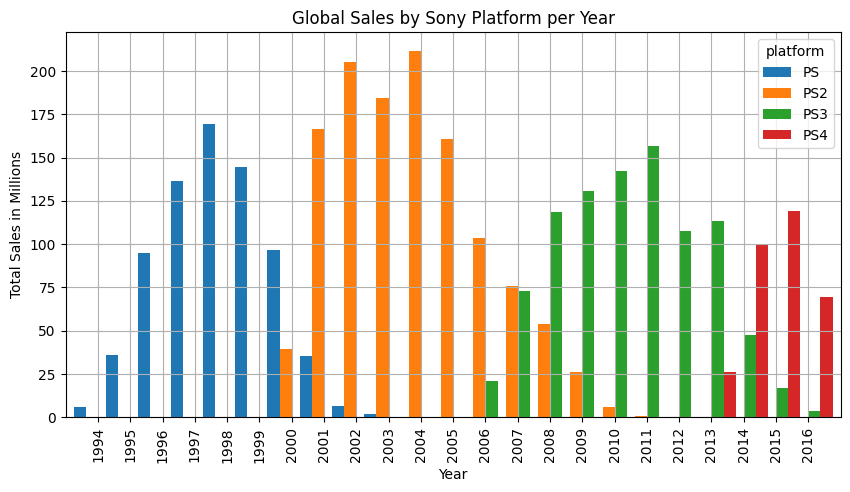

In [16]:
# Platforms that used to be popular but no longer have sales
# Chart for platforms that used to be popular but now have no sales (Sony)
ps_platforms = df_games_clean[df_games_clean["platform"].isin(['PS', 'PS2', 'PS3', 'PS4'])].groupby(["year_of_release","platform"])\
    ["total_sales"].sum().reset_index()

# Filter by platform
pivot_ps_platforms = ps_platforms.pivot(index='year_of_release', columns='platform', values='total_sales')

# Visualization
pivot_ps_platforms.plot(
    title='Global Sales by Sony Platform per Year',
    kind='bar',
    grid=True,
    xlabel='Year',
    ylabel='Total Sales in Millions',
    width=1.5,
    rot=90,
    figsize=(10,5)
)
plt.show()

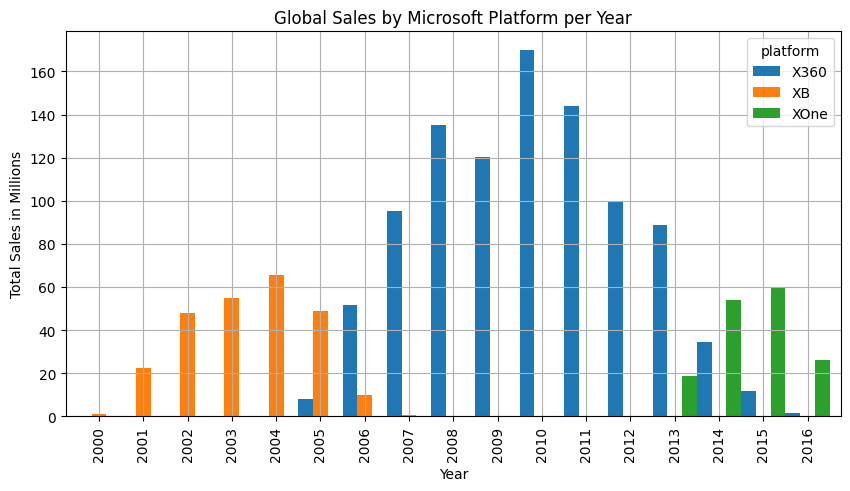

In [17]:
# Chart for platforms that used to be popular but now have no sales (Microsoft)
x_platforms = df_games_clean[df_games_clean["platform"].isin(['XB', 'XOne', 'X360'])].groupby(["year_of_release","platform"])\
    ["total_sales"].sum().reset_index()

# Filter by platform
pivot_x_platforms = x_platforms.pivot(index='year_of_release', columns='platform', values='total_sales')

# Visualization
pivot_x_platforms.plot(
    title='Global Sales by Microsoft Platform per Year',
    kind='bar',
    grid=True,
    xlabel='Year',
    ylabel='Total Sales in Millions',
    width=1,
    rot=90,
    figsize=(10,5)
)
plt.show()

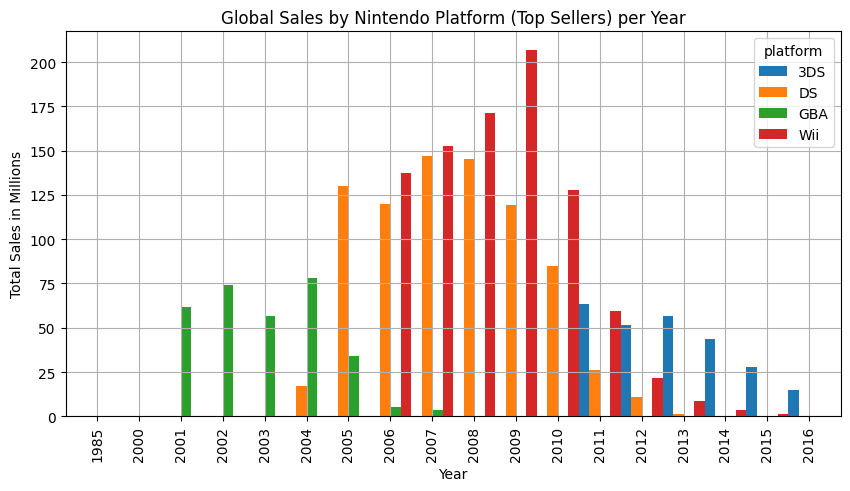

In [18]:
# Chart for platforms that used to be popular but now have no sales (Nintendo "in Top 10")
nin_platforms = df_games_clean[df_games_clean["platform"].isin(['Wii', 'DS', 'GBA', '3DS'])].groupby(["year_of_release","platform"])\
    ["total_sales"].sum().reset_index()

# Filter by platform
pivot_nin_platforms = nin_platforms.pivot(index='year_of_release', columns='platform', values='total_sales')

# Plot the observations
pivot_nin_platforms.plot(
    title='Global Sales by Nintendo Platform (Top Sellers) per Year',
    kind='bar',
    grid=True,
    xlabel='Year',
    ylabel='Total Sales in Millions',
    width=1,
    rot=90,
    figsize=(10,5)
)
plt.show()

Findings: <br>
How long do new platforms usually take to appear and old ones to disappear? <br>
In general, the life cycle of a console (platform) lasts approximately 5 to 7 years before it begins to decline and eventually disappear.
Therefore, for a more accurate forecast for 2017, I will use the 2012–2016 period as a reference (where each platform is at or near its peak), in order to capture the trends of the consoles.

### 3.4 Filtering relevant data

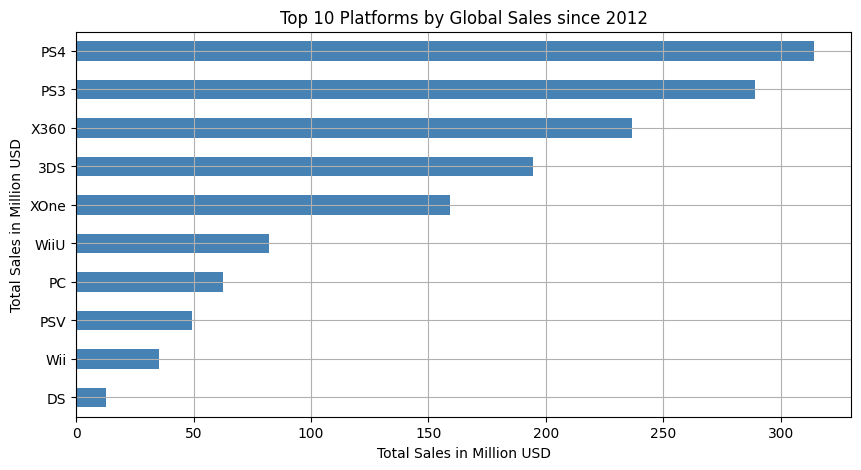

In [19]:
# Data from 2012 onward
sales_per_platform_5y = df_games_clean[df_games_clean['year_of_release'] >= 2012]
sales_5y = sales_per_platform_5y.groupby(by='platform')['total_sales'].sum()
sales_5y = sales_5y.sort_values(ascending=False)

# Plot the observations
ax_5y = sales_5y.head(10).plot(
    title='Top 10 Platforms by Global Sales since 2012',
    kind="barh",
    figsize=(10,5),
    grid=True,
    color='steelblue',
    ylim=(15,30),
    xlabel="Platform",
    ylabel="Total Sales in Million USD"
)
ax_5y.set_xlabel("Total Sales in Million USD")
ax_5y.invert_yaxis()
plt.show()

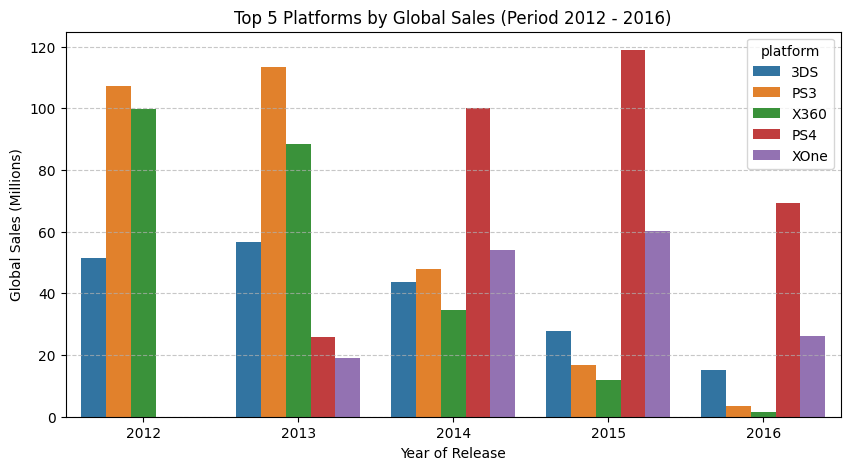

In [20]:
# Select the most representative platforms (Top 5)
top_platforms = sales_5y.head(5).index.tolist()
sales_by_year_platform = df_games_clean[
    (df_games_clean['year_of_release'] >= 2012) & (df_games_clean['platform'].isin(top_platforms))
].groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()

# Plot the observations
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_year_platform, x='year_of_release', y='total_sales', hue='platform')
plt.title('Top 5 Platforms by Global Sales (Period 2012 - 2016)')
plt.xlabel('Year of Release')
plt.ylabel('Global Sales (Millions)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Findings: <br>
Which platforms are leaders in sales? Which ones are growing and which are declining?

By comparing the first chart of the project (which includes all historical data from the dataset) with this chart (which only covers data from 2012 to 2016), the following observations can be made:
- The top 5 platforms based on historical data are: PS2, X360, PS3, Wii, DS.
- The top 5 platforms based on data from 2012 onward are: PS4, PS3, X360, 3DS, XOne.
- The leading platforms in sales are Sony (with PS4 and PS3) and Microsoft (with X360 and XOne).
- As for Nintendo, it lost some ground, managing to remain in the Top 5 only with the 3DS.

### 3.5 Global Sales per Game

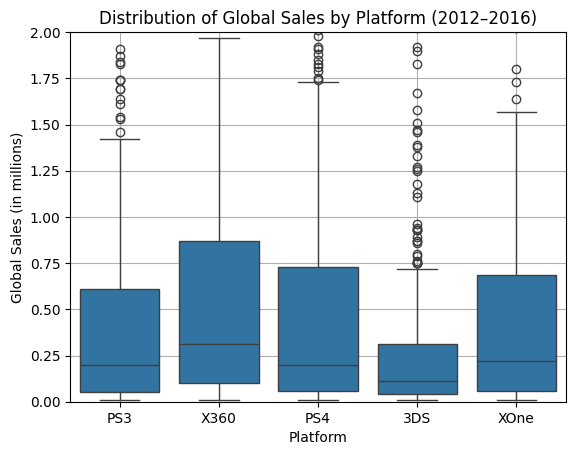

In [21]:
# Box plot for the global sales of all games, broken down by platform.
df_box = df_games_clean[(df_games_clean['year_of_release'] >= 2012) & (df_games_clean['platform'].isin(top_platforms))]

sns.boxplot(x='platform', y='total_sales', data=df_box)
plt.title('Distribution of Global Sales by Platform (2012–2016)')
plt.xlabel('Platform')
plt.ylabel('Global Sales (in millions)')
plt.ylim(0, 2)
plt.grid(True)
plt.show()

Findings: <br>
Are the differences in sales significant? <br>
Based on this Top 5 of global sales platforms for the period 2012–2016, we can see that the medians for most platforms (except X360) remain between 0 and 0.25 million. <Br>
This suggests that the number of major hits is relatively low — low-selling video games dominate the market. <br>
In the case of the X360, there is greater variability, indicating a higher number of successful titles (its sales are more concentrated within its quartiles).

### 3.6 Correlations

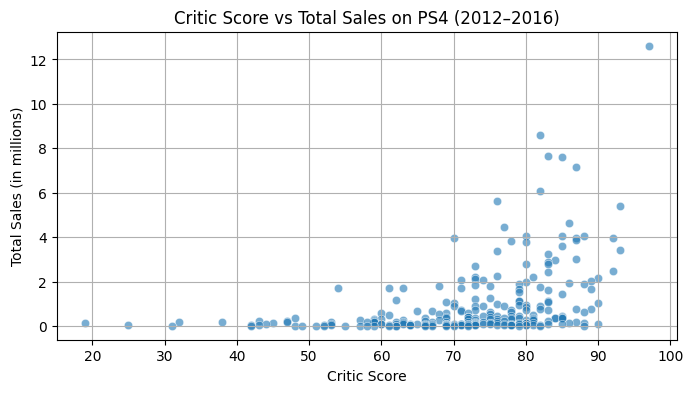

The correlation between critic reviews and sales is: 0.5078289176410228



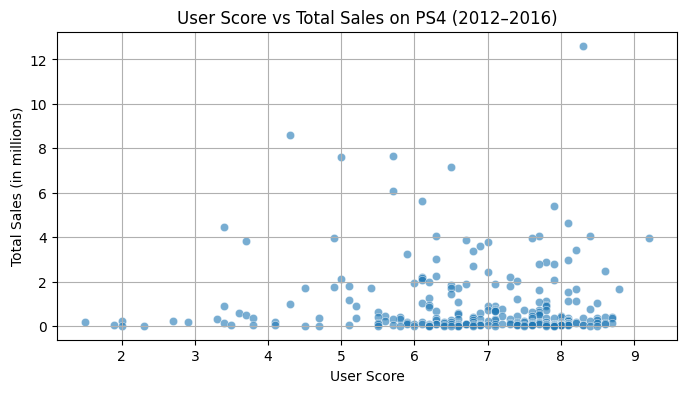

The correlation between user reviews and sales is: -0.032430263114838286



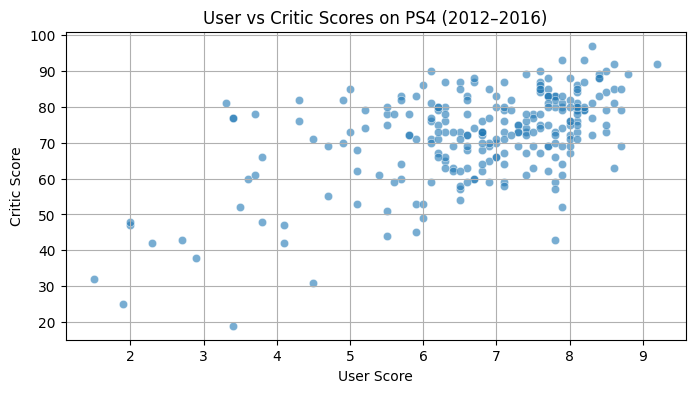

The correlation between user and critic reviews is: 0.43330907203128555


In [22]:
# User and critic reviews on PS4 sales
df_5y = df_games_clean[df_games_clean['year_of_release'] >= 2012].copy()
ps4_data = df_5y[df_5y['platform'] == 'PS4'].dropna(subset=['critic_score', 'user_score'])

# Correlation
correlation_critic = ps4_data['critic_score'].corr(ps4_data['total_sales'], method="spearman")
correlation_user = ps4_data['user_score'].corr(ps4_data['total_sales'], method="spearman")
correlation_critic_user = ps4_data['user_score'].corr(ps4_data['critic_score'], method="spearman")

# Scatter plot: critic score vs sales
plt.figure(figsize=(8, 4))
sns.scatterplot(x='critic_score', y='total_sales', data=ps4_data, alpha=0.6)
plt.title('Critic Score vs Total Sales on PS4 (2012–2016)')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales (in millions)')
plt.grid(True)
plt.show()
print(f'The correlation between critic reviews and sales is: {correlation_critic}')
print()

# Scatter plot: user score vs sales
plt.figure(figsize=(8, 4))
sns.scatterplot(x='user_score', y='total_sales', data=ps4_data, alpha=0.6)
plt.title('User Score vs Total Sales on PS4 (2012–2016)')
plt.xlabel('User Score')
plt.ylabel('Total Sales (in millions)')
plt.grid(True)
plt.show()
print(f'The correlation between user reviews and sales is: {correlation_user}')
print()

# Scatter plot: user score vs critic score
# Comparison between user and critic reviews
plt.figure(figsize=(8, 4))
sns.scatterplot(x='user_score', y='critic_score', data=ps4_data, alpha=0.6)
plt.title('User vs Critic Scores on PS4 (2012–2016)')
plt.xlabel('User Score')
plt.ylabel('Critic Score')
plt.grid(True)
plt.show()
print(f'The correlation between user and critic reviews is: {correlation_critic_user}')

The critic score shows a moderately positive correlation. <br>
This can be interpreted as meaning that higher scores tend to be associated with better sales. <br>
In contrast, the user score shows almost no relationship.<br>
Finally, as a conclusion, the critic score can be used as a parameter to predict the commercial success of future games.

### 3.7 Game sales by platform

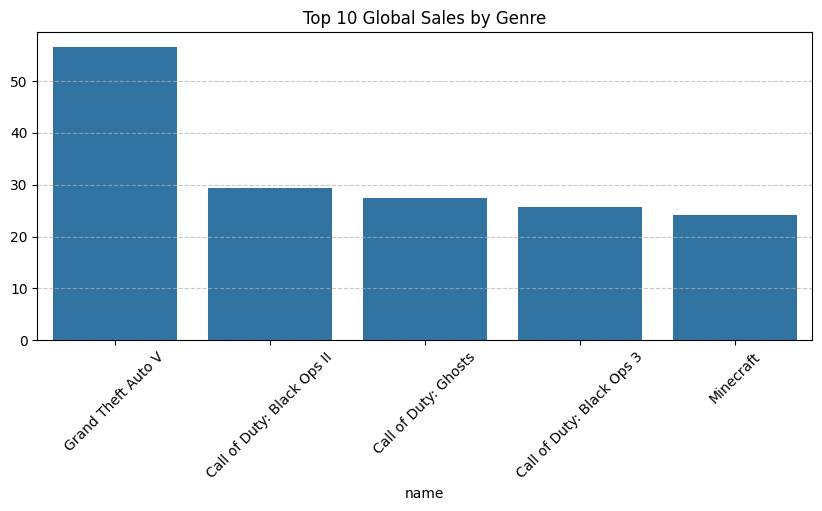

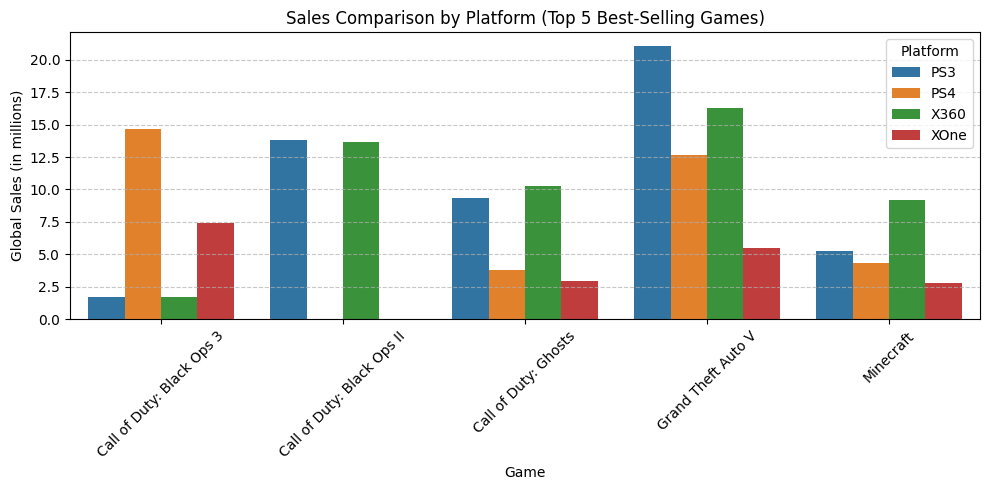

In [23]:
# Considering your previous conclusions, compare the sales of the same games on other platforms.
# First, calculate the Top 5 globally best-selling games.
games_platforms = df_5y.groupby('name')['total_sales'].sum().sort_values(ascending=False).head(5)

# Visualization
plt.figure(figsize=(10,4))
sns.barplot(x=games_platforms.index, y=games_platforms.values)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.title('Top 10 Global Sales by Genre')
plt.show()

# Top 5 Platforms by Global Sales
top5_list = games_platforms.index.tolist()
platforms_to_compare = ['PS3', 'X360', 'PS4', '3DS', 'XOne']

# Filter data
df_top5_platforms = df_5y[(df_5y['name'].isin(top5_list)) & (df_5y['platform'].isin(platforms_to_compare))]
sales_comparison = (df_top5_platforms.groupby(['name', 'platform'])['total_sales'].sum().reset_index())

# visualization of the comparison of game sales across platforms
plt.figure(figsize=(10,5))
sns.barplot(data=sales_comparison, x='name', y='total_sales', hue='platform')
plt.title('Sales Comparison by Platform (Top 5 Best-Selling Games)')
plt.xlabel('Game')
plt.ylabel('Global Sales (in millions)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

### 3.8 Global sales by Genre

genre
Action          1031
Role-Playing     370
Adventure        302
Sports           267
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: count, dtype: int64


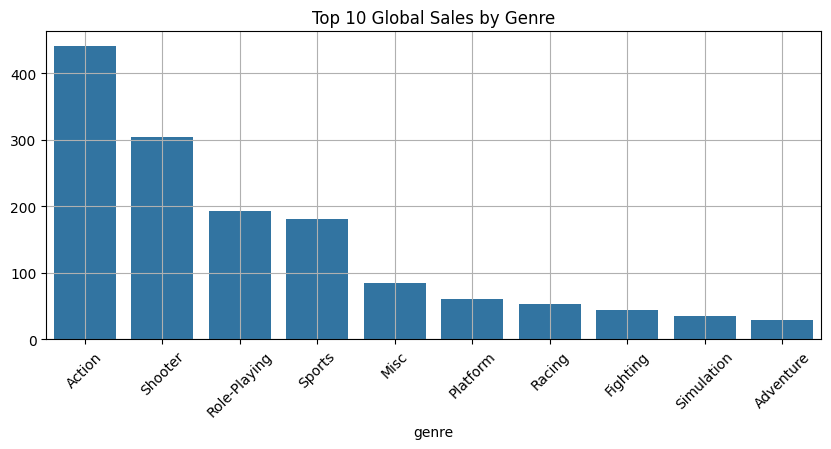

In [24]:
# Distribution of games by genre
genre_sales = df_5y.groupby('genre')['total_sales'].sum().sort_values(ascending=False).head(10)
genre_counts = df_5y['genre'].value_counts()
print(genre_counts)

# Visualization
plt.figure(figsize=(10,4))
sns.barplot(x=genre_sales.index, y=genre_sales.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Top 10 Global Sales by Genre')
plt.show()

Findings: <br>
The most profitable genres (top 3) are Action, Shooter, and Role-Playing. <br>
This information is crucial for the department since, together with critics’ scores, it can serve as a parameter for projecting performance in 2017.

# 4. Create User Profiles by Region
### 4.1 Platforms by Region 

Details of Region: NA
platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64


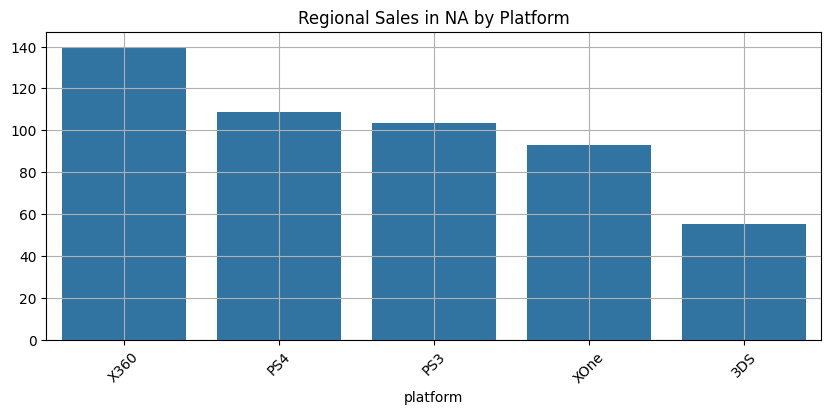

Details of Region: EU
platform
PS4     141.09
PS3     106.85
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64


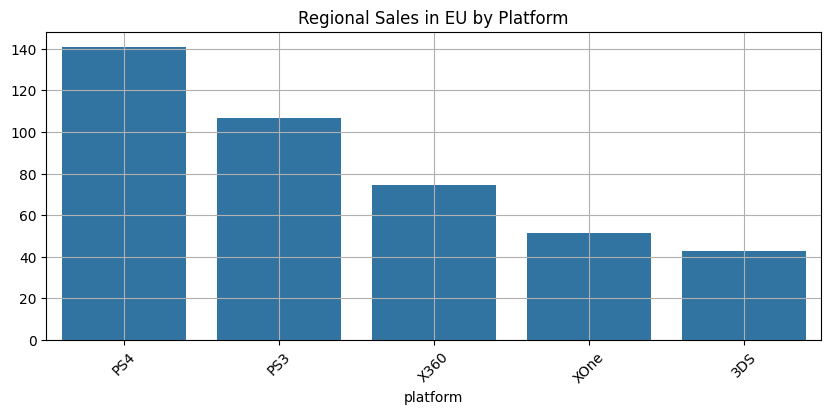

Details of Region: JP
platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64


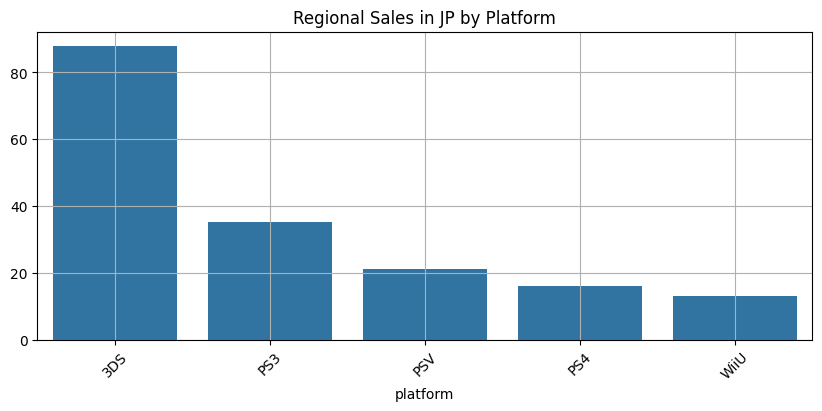

In [25]:
# The top five platforms by region
na_platforms = df_5y.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_platforms = df_5y.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_platforms = df_5y.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Visualization NA
print("Details of Region: NA")
print(na_platforms)
plt.figure(figsize=(10,4))
sns.barplot(x=na_platforms.index, y=na_platforms.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Regional Sales in NA by Platform')
plt.show()

# Visualization EU
print("Details of Region: EU")
print(eu_platforms)
plt.figure(figsize=(10,4))
sns.barplot(x=eu_platforms.index, y=eu_platforms.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Regional Sales in EU by Platform')
plt.show()

# Visualization JP
print("Details of Region: JP")
print(jp_platforms)
plt.figure(figsize=(10,4))
sns.barplot(x=jp_platforms.index, y=jp_platforms.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Regional Sales in JP by Platform')
plt.show()

Findings: <br>
Platform Conclusions <br>

- In both Europe (EU) and North America (NA), there is a similarity in preferences for Sony and Microsoft platforms. 
- In NA, the preferred platform is X360, followed by two of Sony’s platforms.
- In EU, the favorite is PS4, followed by PS3, and then Microsoft’s console.
- In contrast, the Japanese (JP) market shows a clear preference for Nintendo DS, followed by Sony platforms. No Microsoft platforms appear in Japan’s Top 5.

### 4.2 Genres by Region

Details of Region: NA
genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64


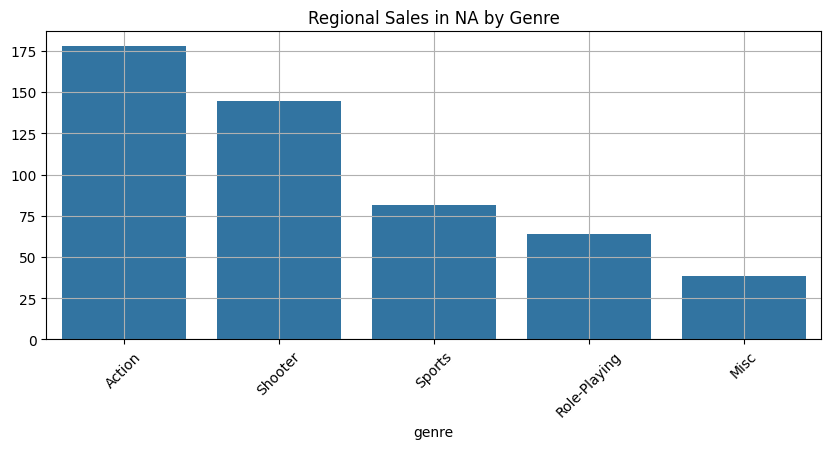

Details of Region: EU
genre
Action          159.34
Shooter         113.47
Sports           69.08
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64


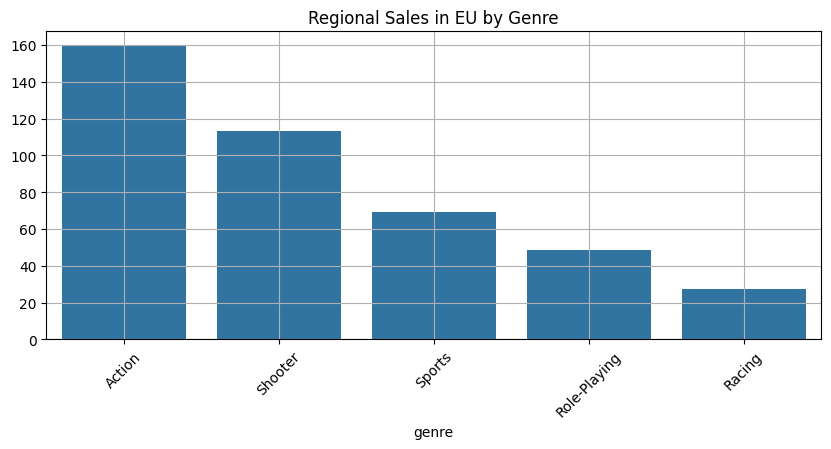

Details of Region: JP
genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64


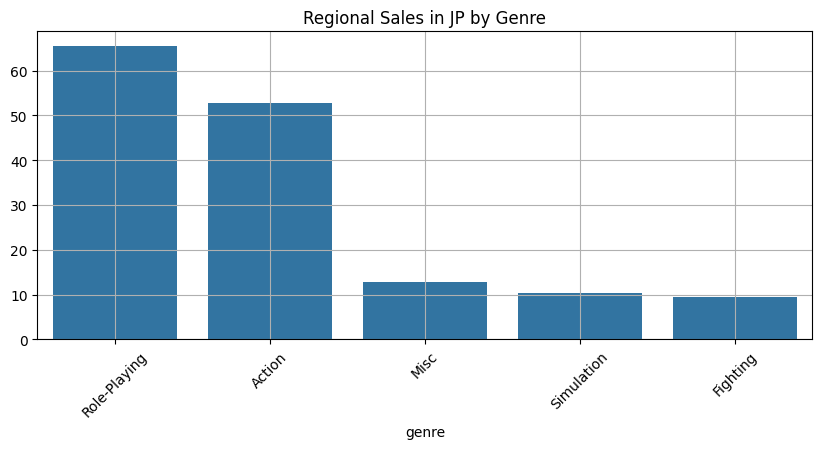

In [26]:
# Top 5 main genres by region
na_genres = df_5y.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_genres = df_5y.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_genres = df_5y.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Visualization NA
print("Details of Region: NA")
print(na_genres)
plt.figure(figsize=(10,4))
sns.barplot(x=na_genres.index, y=na_genres.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Regional Sales in NA by Genre')
plt.show()

# Visualization EU
print("Details of Region: EU")
print(eu_genres)
plt.figure(figsize=(10,4))
sns.barplot(x=eu_genres.index, y=eu_genres.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Regional Sales in EU by Genre')
plt.show()

# Visualization JP
print("Details of Region: JP")
print(jp_genres)
plt.figure(figsize=(10,4))
sns.barplot(x=jp_genres.index, y=jp_genres.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Regional Sales in JP by Genre')
plt.show()

Findings: <br>
In the case of North America (NA) and Europe (EU), there are many similarities in game preferences, with the Top 4 genres being nearly identical: Action, Shooter, Sports, and Role-Playing. <br>
In contrast, Japan (JP) shows a significantly different pattern, where the most popular genres are Role-Playing, Action, and Misc. <br>
This is quite interesting, as NA and EU share similar preferences, whereas JP stands out with very distinct gaming tastes.

### 4.3 ESRB Ratings and Regional Sales

Details of Region: NA
rating
M       231.57
E       114.37
E10+     75.70
T        66.02
Name: na_sales, dtype: float64


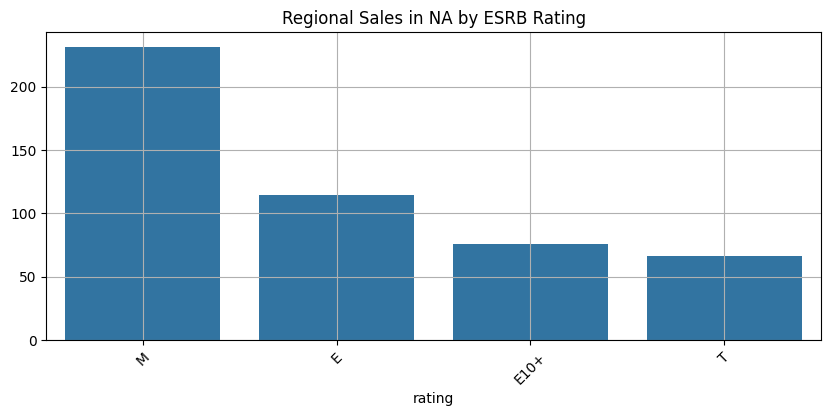

Details of Region: EU
rating
M       193.96
E       113.02
E10+     55.37
T        52.96
Name: eu_sales, dtype: float64


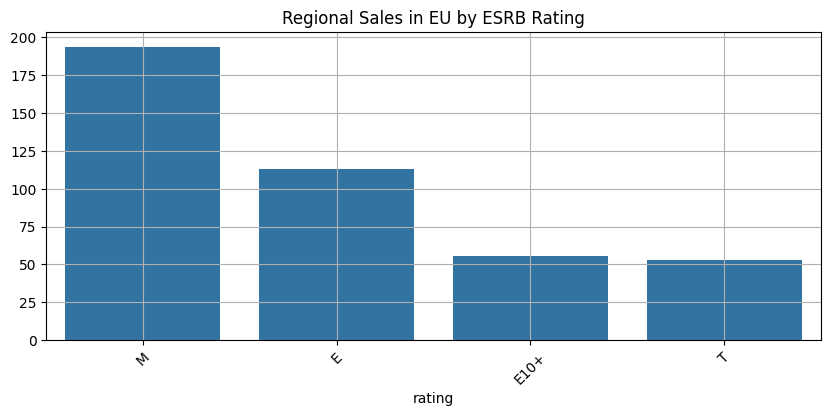

Details of Region: JP
rating
E       28.33
T       26.02
M       21.20
E10+     8.19
Name: jp_sales, dtype: float64


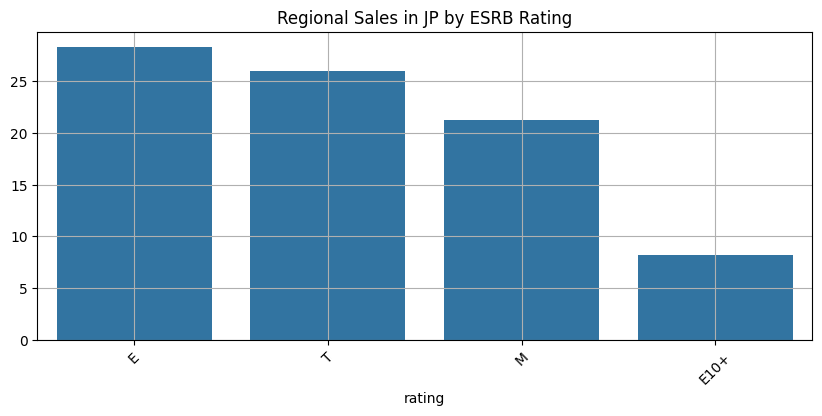

In [27]:
# Top 5 ESRB ratings by region
na_rating = df_5y.groupby('rating')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_rating = df_5y.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_rating = df_5y.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Visualization NA
print("Details of Region: NA")
print(na_rating)
plt.figure(figsize=(10,4))
sns.barplot(x=na_rating.index, y=na_rating.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Regional Sales in NA by ESRB Rating')
plt.show()

# Visualization EU
print("Details of Region: EU")
print(eu_rating)
plt.figure(figsize=(10,4))
sns.barplot(x=eu_rating.index, y=eu_rating.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Regional Sales in EU by ESRB Rating')
plt.show()

# Visualization JP
print("Details of Region: JP")
print(jp_rating)
plt.figure(figsize=(10,4))
sns.barplot(x=jp_rating.index, y=jp_rating.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Regional Sales in JP by ESRB Rating')
plt.show()

Findings: Rating vs Sales by Region <br>
The conclusion from comparing ESRB ratings and sales by region is that Japan (JP) clearly stands out as a unique niche, differing significantly from Europe (EU) and North America (NA) — which, in contrast, show very similar patterns. <br>
For EU and NA, the most popular rating is “M” (Mature), while in JP, the preferred rating is “E” (Everyone).

# 5. Testing Hypothesis
Hypothesis 1:
- H₀: There is no difference between the average user ratings for Xbox One and PC platforms.
mean_user_score("XOne") = mean_user_score("PC")

- H₁: There is a difference between the average user ratings for Xbox One and PC platforms.
mean_user_score("XOne") ≠ mean_user_score("PC")

Hypothesis 2: 
- H₀: There is no difference between the average user ratings for Action and Sports genres.
mean_user_score("action") = mean_user_score("sports")

- H₁: There is a difference between the average user ratings for Action and Sports genres.
mean_user_score("action") ≠ mean_user_score("sports")

In [28]:
# Significance level
alpha = 0.05

### 5.1 Hypothesis Testing Using Historical Data
Hypothesis 1: Xbox One vs PC

Significance level: 0.05

Levene test p-value:  0.27955
Fail to reject the null hypothesis — the variances are not significantly different.

T-statistic: -4.3828953
P-value:  0.0000130
Reject the null hypothesis — average user ratings by platform are significantly different.



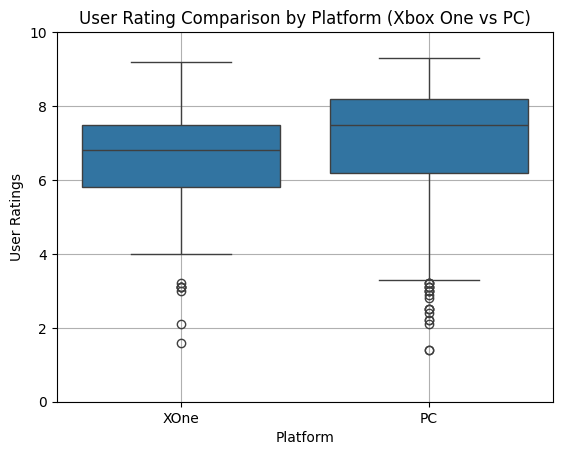

In [29]:
# Filtered Data (XOne vs PC)
xone_score = df_games_clean[(df_games_clean['platform'] == 'XOne') & (df_games_clean['user_score'].notna())]['user_score']
pc_score = df_games_clean[(df_games_clean['platform'] == 'PC') & (df_games_clean['user_score'].notna())]['user_score']

print(f'Significance level: {alpha}')
print()

# Combine data into new DataFrames
xone_df = pd.DataFrame({'platform': ['XOne'] * len(xone_score), 'user_score': xone_score.values})
pc_df = pd.DataFrame({'platform': ['PC'] * len(pc_score), 'user_score': pc_score.values})
concat_xone_pc = pd.concat([xone_df, pc_df], ignore_index=True)

# Variance test (Levene test)
statistics, p_value = stats.levene(xone_score, pc_score)
print(f'Levene test p-value: {p_value: .5f}')
if (p_value < alpha):
    print("Reject the null hypothesis — the variances are different.")
else:
    print("Fail to reject the null hypothesis — the variances are not significantly different.")
print()

# Since Levene's test showed variances are not different, we can use a two-tailed t-test
t_stat, p_value = stats.ttest_ind(xone_score, pc_score, equal_var=True)
print(f'T-statistic: {t_stat: .7f}')
print(f'P-value: {p_value: .7f}')

if p_value < alpha:
    print("Reject the null hypothesis — average user ratings by platform are significantly different.")
else:
    print("Fail to reject the null hypothesis — there is enough evidence to conclude that average user ratings by platform are the same.")
print()

# Boxplot comparison
sns.boxplot(x='platform', y='user_score', data=concat_xone_pc)
plt.title("User Rating Comparison by Platform (Xbox One vs PC)")
plt.xlabel('Platform')
plt.ylabel('User Ratings')
plt.ylim(0, 10)
plt.grid(True)
plt.show()

Hypothesis 2: Action vs Sports Genres

Significance level: 0.05

Levene test p-value:  0.00009
Reject the null hypothesis — the variances are different.

T-statistic:  1.7661671
P-value:  0.0775167
Fail to reject the null hypothesis — there is enough evidence to conclude that the average user ratings are the same.



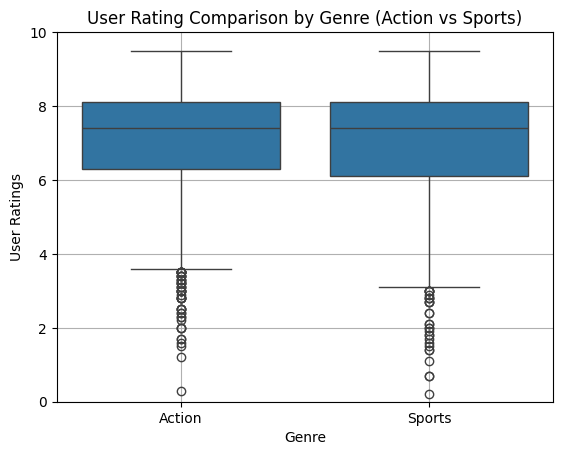

In [30]:
# Filtered Data (Action vs Sports)
action_score = df_games_clean[(df_games_clean['genre'] == 'Action') & (df_games_clean['user_score'].notna())]['user_score']
sports_score = df_games_clean[(df_games_clean['genre'] == 'Sports') & (df_games_clean['user_score'].notna())]['user_score']
# print('N Action:', action_score.shape[0], 'N Sports:', sports_score.shape[0])
print(f'Significance level: {alpha}')
print()

# Combine data into new columns
action_df = pd.DataFrame({'genre': ['Action'] * len(action_score), 'user_score': action_score.values})
sports_df = pd.DataFrame({'genre': ['Sports'] * len(sports_score), 'user_score': sports_score.values})
concat_action_sports = pd.concat([action_df, sports_df], ignore_index=True)

# Hypothesis Testing
# Variance evaluation (Action vs Sports) using Levene's test
statistics, p_value = stats.levene(action_score, sports_score)
print(f'Levene test p-value: {p_value: .5f}')
if (p_value < alpha):
    print("Reject the null hypothesis — the variances are different.")
else:
    print("Fail to reject the null hypothesis — the variances are not significantly different.")
print()

# In this case, Levene’s test showed that the variances are different.
t_stat, p_value = stats.ttest_ind(action_score, sports_score, equal_var=False)
print(f'T-statistic: {t_stat: .7f}')
print(f'P-value: {p_value: .7f}')

if p_value < alpha:
    print("Reject the null hypothesis — the average user ratings are significantly different.")
else:
    print("Fail to reject the null hypothesis — there is enough evidence to conclude that the average user ratings are the same.")
print()

# Boxplot comparison
sns.boxplot(x='genre', y='user_score', data=concat_action_sports)
plt.title("User Rating Comparison by Genre (Action vs Sports)")
plt.xlabel('Genre')
plt.ylabel('User Ratings')
plt.ylim(0, 10)
plt.grid(True)
plt.show()

### 5.2 Hypothesis using data from the platform life cycle (5 years)
Hypothesis 1: Xbox One vs PC

significance level: 0.05

Levene test p-value:  0.01251
Null hypothesis is rejected, since the variances are different

Test statistic result:  0.5998586
p_value:  0.5489538
We cannot reject the null hypothesis, since there is enough evidence to show that the average user ratings by platform are equal



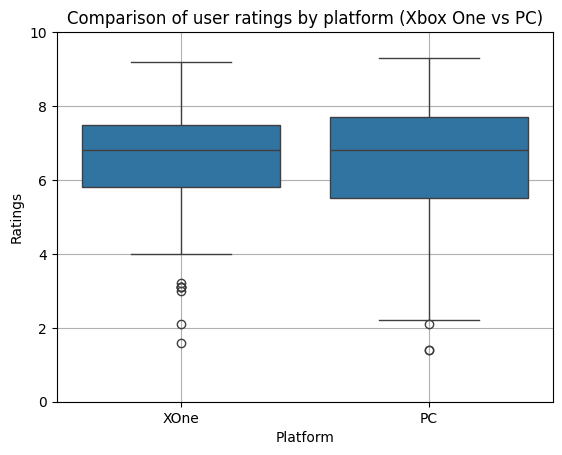

In [31]:
# Data Filtering (XOne vs PC)
xone_score_5y = df_5y[(df_5y['platform'] == 'XOne') & (df_5y['user_score'].notna())]['user_score']
pc_score_5y = df_5y[(df_5y['platform'] == 'PC') & (df_5y['user_score'].notna())]['user_score']
print(f'significance level: {alpha}')
print()

# Grouping data into new columns
xone_df_5y = pd.DataFrame({'platform': ['XOne'] * len(xone_score_5y), 'user_score': xone_score_5y.values})
pc_df_5y = pd.DataFrame({'platform': ['PC'] * len(pc_score_5y), 'user_score': pc_score_5y.values})
concat_xone_pc_5y = pd.concat([xone_df_5y, pc_df_5y], ignore_index=True)

# Hypothesis Testing
# Evaluation of variances (XOne vs PC) using Levene’s test
statistics, p_value = stats.levene(xone_score_5y, pc_score_5y)
print(f'Levene test p-value: {p_value: .5f}')
if (p_value < alpha):
    print("Null hypothesis is rejected, since the variances are different")
else:
    print("Null hypothesis is not rejected, since the variances are not different")
print()

# In this case, through variance evaluation (Levene’s test), it was shown that the variances are different.
t_stat, p_value = stats.ttest_ind(xone_score_5y, pc_score_5y, equal_var=False)
print(f'Test statistic result: {t_stat: .7f}')
print(f'p_value: {p_value: .7f}')

if p_value < alpha:
    print("Null hypothesis is rejected, since the average user ratings by platform are not equal")
else:
    print("We cannot reject the null hypothesis, since there is enough evidence to show that the average user ratings by platform are equal")
print()

# Boxplot to show the comparisons.
sns.boxplot(x='platform', y='user_score', data=concat_xone_pc_5y)
plt.title("Comparison of user ratings by platform (Xbox One vs PC)")
plt.xlabel('Platform')
plt.ylabel('Ratings')
plt.ylim(0,10)
plt.grid(True)
plt.show()

Hypothesis 2: Action vs Sports Genres

significance level: 0.05

Levene test p-value: 1.045718795108326e-05
The null hypothesis is rejected, since the variances are different

Test statistic result: 9.863487132322389
p_value: 5.989458066467418e-20
The null hypothesis is rejected, since the average user ratings are not equal



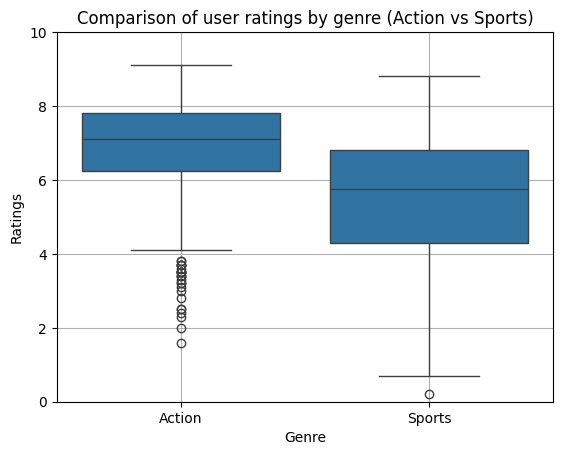

In [32]:
# Data Filtering (Action vs Sports)
action_score_5y = df_5y[(df_5y['genre'] == 'Action') & (df_5y['user_score'].notna())]['user_score']
sports_score_5y = df_5y[(df_5y['genre'] == 'Sports') & (df_5y['user_score'].notna())]['user_score']
# print('N Action:', action_score.shape[0], 'N Sports:', sports_score.shape[0])
print(f'significance level: {alpha}')
print()

# Grouping data into new columns
action_df_5y = pd.DataFrame({'genre': ['Action'] * len(action_score_5y), 'user_score': action_score_5y.values})
sports_df_5y = pd.DataFrame({'genre': ['Sports'] * len(sports_score_5y), 'user_score': sports_score_5y.values})
concat_action_sports_5y = pd.concat([action_df_5y, sports_df_5y], ignore_index=True)

# Hypothesis Testing
# Evaluation of variances (Action vs Sports) using Levene’s test
statistics, p_value = stats.levene(action_score_5y, sports_score_5y)
print(f'Levene test p-value: {p_value}')
if (p_value < alpha):
    print("The null hypothesis is rejected, since the variances are different")
else:
    print("The null hypothesis is not rejected, since the variances are not different")
print()

# In this case, through variance evaluation (Levene’s test), it was shown that the variances are different.
t_stat, p_value = stats.ttest_ind(action_score_5y, sports_score_5y, equal_var=False)
print(f'Test statistic result: {t_stat}')
print(f'p_value: {p_value}')

if p_value < alpha:
    print("The null hypothesis is rejected, since the average user ratings are not equal")
else:
    print("We cannot reject the null hypothesis, since there is enough evidence to show that the average user ratings are equal")
print()

# Boxplot to show the comparisons.
sns.boxplot(x='genre', y='user_score', data=concat_action_sports_5y)
plt.title("Comparison of user ratings by genre (Action vs Sports)")
plt.xlabel('Genre')
plt.ylabel('Ratings')
plt.ylim(0,10)
plt.grid(True)
plt.show()

How the Null and Alternative Hypotheses Were Formulated: <br>
<br>
To test or reject the two proposed hypotheses, it was first necessary to determine whether the variances of the two samples were equal or different (both for the hypothesis regarding average ratings between platforms and for the hypothesis regarding average ratings between genres). 
<br>
In my particular case, I conducted both hypotheses twice, once using the complete historical dataset, and again using only the data from the period 2012–2016, which produced some very interesting results:

- For the historical data, it was shown that the variances of both samples (“XOne” and “PC”) were similar, so I used the traditional Student’s t-test. In the end, the null hypothesis was rejected, since the average user ratings by platform are not equal.
- For that same hypothesis using data from 2012–2016, it was shown that the variances of both samples (“XOne” and “PC”) were different, so I used Welch’s t-test. In the end, we cannot reject the null hypothesis, as there is sufficient evidence showing that the average user ratings by platform are equal.
- For the historical data in the genre hypothesis, it was shown that the variances of both samples (“Action” and “Sports”) were different, so I used Welch’s t-test. In the end, we cannot reject the null hypothesis, as there is sufficient evidence showing that the average user ratings are equal.
- For that same hypothesis using data from 2012–2016, it was shown again that the variances of both samples were different, so I used Welch’s t-test. In the end, the null hypothesis was rejected, since the average user ratings are not equal.

# 6. Conclusion
This analysis was carried out with the goal of identifying patterns of success in video games for the Ice online store, using historical data up to December 2016 to plan the 2017 advertising campaign. <br>
The first crucial stage was data preparation, which involved handling a significant number of missing values, particularly in critic_score and user_score, and converting data types, such as standardizing “tbd” to NaN in user scores. Finally, the key points of the project to consider were: <br>

Relevant Period Identified
- The analysis of the console life cycle shows that their active commercial lifespan is typically 5 to 7 years. Therefore, to forecast 2017, data from the 2012–2016 period was used, discarding obsolete historical data.

Platforms with Potential
- In 2016, the previous-generation platforms (PS3, X360) were clearly in decline.
- The platforms with the greatest potential for sales and growth in 2017 were PS4 and XOne.

Key Sales Factors (Global)
- Critic scores (critic_score) show a moderate positive correlation (0.51) with global sales, making them a reliable indicator of success.
- User scores (user_score) did not show a significant correlation (-0.03).
- Most Profitable Genres: Globally, the most successful and highest-grossing genres during the relevant period were Action, Shooter, and Role-Playing.

Market Profile (NA and EU)
- North America and Europe are very similar markets. 
- Preferred platforms: PS4 and XOne (Sony and Microsoft). 
- Preferred genres: Action and Shooter. 
- Preferred rating: “M” (Mature – Adult). 

Market Profile (JP)
- The Japanese market is completely different and requires a separate strategy. 
- Preferred platforms: 3DS and PSV (dominated by Nintendo and Sony handhelds). 
- Preferred genre: Role-Playing. 
- Preferred rating: “E” (Everyone).

Hypothesis Testing Results (2012–2016 Period)
- The null hypothesis was accepted for platforms: 
- Average user ratings between XOne and PC are not significantly different (p-value > 0.05).

- The null hypothesis was rejected for genres: 
- Average user ratings between Action and Sports are significantly different (p-value < 0.05).

Strategic Recommendation for 2017
- For NA/EU: Invest in advertising for Action and Shooter games with high critic ratings on PS4 and XOne.
- For JP: Focus advertising efforts on Role-Playing games for the 3DS platform.